# Data exploration



In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyspark.sql.functions as psqlf

In [3]:
df_1 = pd.read_csv('~/notebook/work/PS_20174392719_1491204439457_log.csv')

Function for stratified down sampling of the dataset (which is too big for free tier of IBM cloud, therefore down sampling)

In [4]:
def fold_ctrl (fun_df, folds_no):
    fun_no_of_rows = len(fun_df)
    np.random.seed(23434)
    vect = np.random.choice(range(folds_no), size = fun_no_of_rows , p=np.full((1, folds_no), 1/folds_no)[0])
    return pd.DataFrame(vect)

In [5]:
df_1 = pd.concat([df_1.groupby(['isFraud', 'step' , 'type']).apply(lambda x:fold_ctrl (x , 120  ) ).reset_index(drop=True).rename({0:'folds'}, axis=1) ,
    df_1], axis=1)

Let’s have a look at the data

In [6]:
df_1.head()

,folds,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,110,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,88,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,20,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,110,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,6,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [7]:
len(df_1)

6362620

Let’s create Spark session and load data

In [9]:
spark = SparkSession\
    .builder\
    .getOrCreate()

In [10]:
spark

In [29]:
spark_df1 = spark.createDataFrame(df_1.query('folds<25'))

In [30]:
spark_df1

DataFrame[folds: bigint, step: bigint, type: string, amount: double, nameOrig: string, oldbalanceOrg: double, newbalanceOrig: double, nameDest: string, oldbalanceDest: double, newbalanceDest: double, isFraud: bigint, isFlaggedFraud: bigint]

In [31]:
spark_df1.take(2)

[Row(folds=20, step=1, type='TRANSFER', amount=181.0, nameOrig='C1305486145', oldbalanceOrg=181.0, newbalanceOrig=0.0, nameDest='C553264065', oldbalanceDest=0.0, newbalanceDest=0.0, isFraud=1, isFlaggedFraud=0),
 Row(folds=6, step=1, type='PAYMENT', amount=11668.14, nameOrig='C2048537720', oldbalanceOrg=41554.0, newbalanceOrig=29885.86, nameDest='M1230701703', oldbalanceDest=0.0, newbalanceDest=0.0, isFraud=0, isFlaggedFraud=0)]

Let’s check datatypes of the columns

In [32]:
df_1.get_dtype_counts()

float64    5
int64      4
object     3
dtype: int64

In [33]:
df_1.dtypes

folds               int64
step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

In [34]:
numericCols = df_1.select_dtypes(include=['float64', 'int64']).columns
numericCols

Index(['folds', 'step', 'amount', 'oldbalanceOrg', 'newbalanceOrig',
       'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud'],
      dtype='object')

In [35]:
charCols = df_1.select_dtypes(include=['object']).columns
charCols

Index(['type', 'nameOrig', 'nameDest'], dtype='object')

### Check for missing values



   
 





In [36]:
{ x: spark_df1.select(psqlf.when(psqlf.isnull(x),1).otherwise(0).alias("r1")).agg(psqlf.sum('r1').alias("No_of_nulls")).collect()[0]["No_of_nulls"]  for x in df_1.columns}

{'amount': 0,
 'folds': 0,
 'isFlaggedFraud': 0,
 'isFraud': 0,
 'nameDest': 0,
 'nameOrig': 0,
 'newbalanceDest': 0,
 'newbalanceOrig': 0,
 'oldbalanceDest': 0,
 'oldbalanceOrg': 0,
 'step': 0,
 'type': 0}

Luckily there are none

### Let’s check metrics describing distributions of numeric columns

In [37]:
spark_df1.describe(numericCols.tolist()).show()

+-------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+--------------------+--------------------+
|summary|             folds|              step|            amount|    oldbalanceOrg|    newbalanceOrig|    oldbalanceDest|    newbalanceDest|             isFraud|      isFlaggedFraud|
+-------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+--------------------+--------------------+
|  count|           1321313|           1321313|           1321313|          1321313|           1321313|           1321313|           1321313|             1321313|             1321313|
|   mean|12.132573432638596|243.36235471837483|180162.11258198577|832537.8160940136| 853746.6354102041|1103761.4812853439|1228437.1842058613|0.001282814897000181|3.027291792330810...|
| stddev| 7.270607982569034| 142.0173477507629| 598686.9929991994| 2881825.98356

In [38]:
spark_df1.agg(psqlf.skewness(spark_df1.amount) , psqlf.kurtosis(spark_df1.amount) ,
             psqlf.skewness(spark_df1.oldbalanceOrg) , psqlf.kurtosis(spark_df1.oldbalanceOrg),
             psqlf.skewness(spark_df1.newbalanceOrig) , psqlf.kurtosis(spark_df1.newbalanceOrig),
             psqlf.skewness(spark_df1.oldbalanceDest) , psqlf.kurtosis(spark_df1.oldbalanceDest),
             psqlf.skewness(spark_df1.newbalanceDest) , psqlf.kurtosis(spark_df1.newbalanceDest)).toPandas()

,skewness(amount),kurtosis(amount),skewness(oldbalanceOrg),kurtosis(oldbalanceOrg),skewness(newbalanceOrig),kurtosis(newbalanceOrig),skewness(oldbalanceDest),kurtosis(oldbalanceDest),skewness(newbalanceDest),kurtosis(newbalanceDest)
0,29.8872,1654.078958,5.238133,32.800878,5.165532,31.900688,20.639054,1009.337718,19.643684,887.418184


### Let’s check character columns

In [39]:
spark_df1.describe(charCols.tolist()).show()

+-------+--------+-----------+-----------+
|summary|    type|   nameOrig|   nameDest|
+-------+--------+-----------+-----------+
|  count| 1321313|    1321313|    1321313|
|   mean|    null|       null|       null|
| stddev|    null|       null|       null|
|    min| CASH_IN|C1000001725|C1000004082|
|    max|TRANSFER|  C99999367| M999999543|
+-------+--------+-----------+-----------+



### Let’s explore values in the columns

Let’s summarize data in Spark and then operate in Pandas

 

In [40]:
viz_df1 = spark_df1.groupBy('type', 'isFraud', 'step').count().toPandas()
viz_df1.head()

,type,isFraud,step,count
0,TRANSFER,1,454,2
1,CASH_OUT,0,570,134
2,PAYMENT,0,673,37
3,DEBIT,0,684,4
4,CASH_IN,0,686,227


### Target value
 
  

In [42]:
viz_df1.groupby('isFraud').agg({'count': sum})

,count
isFraud,
0,1319618
1,1695


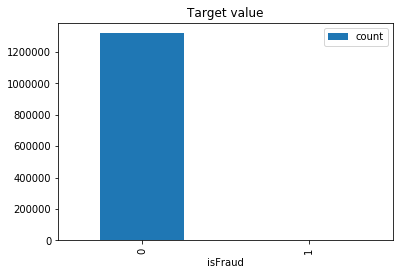

In [44]:
viz_df1.groupby('isFraud').agg({'count': sum}).plot.bar(title = "Target value")

##### As we can see from table and graph above, there is a very significant imbalance between the two classes

### Transaction types

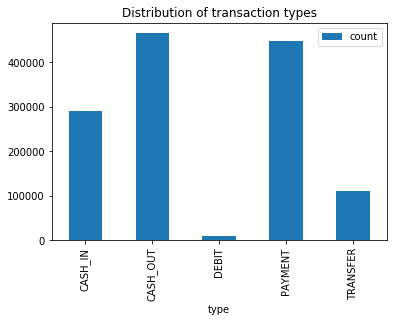

In [46]:
viz_df1.groupby('type').agg({'count': sum}).plot.bar(title = 'Distribution of transaction types')

Distribution of transaction types by target value

In [47]:
viz_df2 = viz_df1[['type', 'isFraud' , 'count']].groupby(['type', 'isFraud']).agg({'count': sum}).reset_index(drop =False).pivot(index='type', columns='isFraud' , values='count').fillna(0)
viz_df2

isFraud,0,1
type,,
CASH_IN,290552.0,0.0
CASH_OUT,464182.0,841.0
DEBIT,8496.0,0.0
PAYMENT,446191.0,0.0
TRANSFER,110197.0,854.0


As we can see from table and graph above, fraudulent transactions occur only on types ‘CASH_OUT’ and ‘TRANSFER’

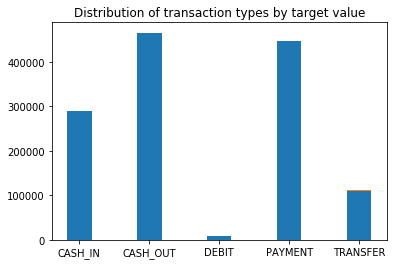

In [54]:
plt.title('Distribution of transaction types by target value')
p1 = plt.bar(viz_df2.index, viz_df2.iloc[:,0], width = 0.35  )
p2 = plt.bar(viz_df2.index, viz_df2.iloc[:,1], width = 0.35  ,
            bottom= viz_df2.iloc[:, 0])
plt.show()

### Transaction types over time

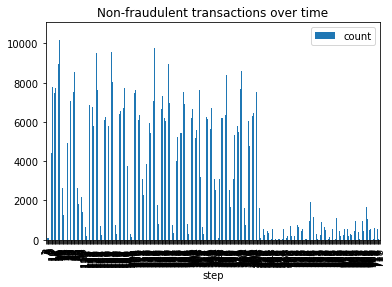

In [74]:
viz_df1.query('isFraud == 0 ').groupby('step').agg({'count' :sum}).plot.bar(title = 'Non-fraudulent transactions over time')

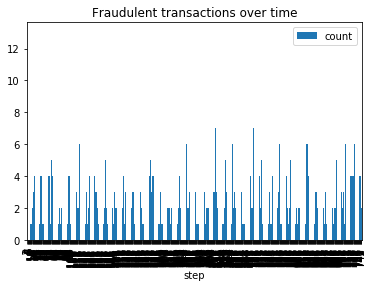

In [75]:
viz_df1.query('isFraud == 1').groupby('step').agg({'count' :sum}).plot.bar(title = 'Fraudulent transactions over time')

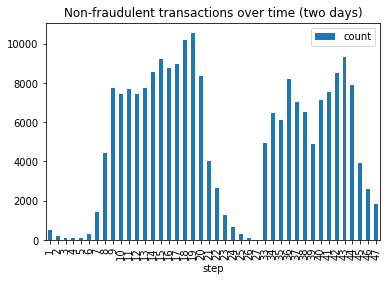

In [76]:
viz_df1.query('isFraud == 0 and step <48').groupby('step').agg({'count' :sum}).plot.bar(title = 'Non-fraudulent transactions over time (two days)')

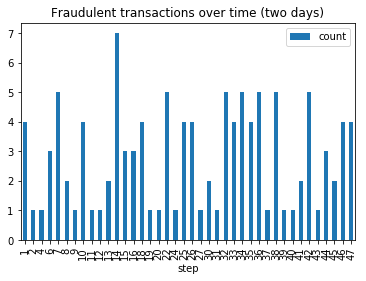

In [77]:
viz_df1.query('isFraud == 1 and step <48').groupby('step').agg({'count' :sum}).plot.bar(title = 'Fraudulent transactions over time (two days)')

##### Looks like there is a weak correlation between overall number of transactions and number of fraudulent transactions

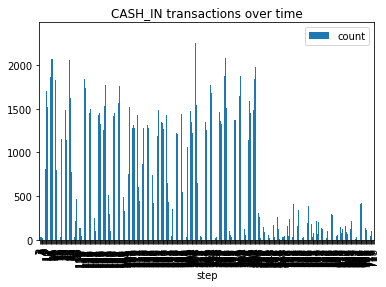

In [84]:
viz_df1.query('type == "CASH_IN"').groupby('step').agg({'count' :sum}).plot.bar(title = 'CASH_IN transactions over time')

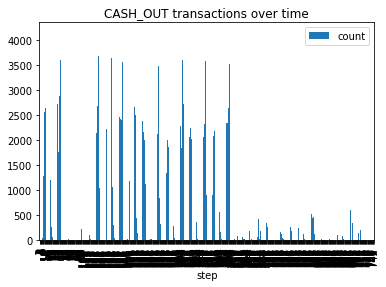

In [85]:
viz_df1.query('type == "CASH_OUT"').groupby('step').agg({'count' :sum}).plot.bar(title = 'CASH_OUT transactions over time')

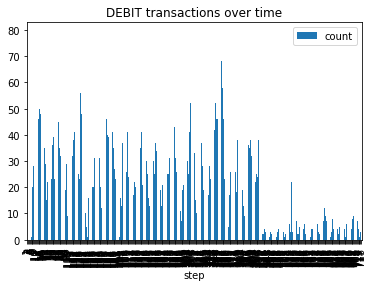

In [86]:
viz_df1.query('type == "DEBIT"').groupby('step').agg({'count' :sum}).plot.bar(title = 'DEBIT transactions over time')

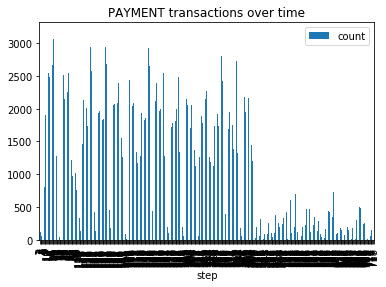

In [87]:
viz_df1.query('type == "PAYMENT"').groupby('step').agg({'count' :sum}).plot.bar(title = 'PAYMENT transactions over time')

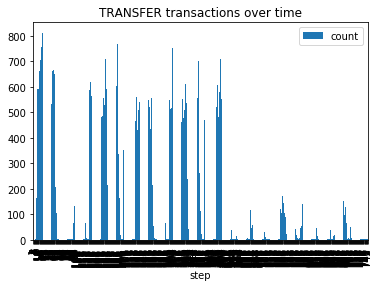

In [88]:
viz_df1.query('type == "TRANSFER"').groupby('step').agg({'count' :sum}).plot.bar(title = 'TRANSFER transactions over time')

### Parties involved in transactions

In [89]:
viz_df3 = spark_df1.groupBy('nameOrig').count().toPandas().sort_values(by='count' , ascending = False)
viz_df3.head()

,nameOrig,count
382819,C2066844248,2
112925,C1022299134,2
325658,C1410151632,2
641868,C1599036327,2
702700,C1623366178,2


In [90]:
viz_df4 = spark_df1.groupBy('nameDest').count().toPandas().sort_values(by='count' , ascending = False)
viz_df4.head()

,nameDest,count
120228,C248609774,31
257447,C985934102,30
175861,C665576141,28
767614,C1234776885,27
715823,C2083562754,24


Looks like only destination accounts appear in the data numerous times (more than two)

In [91]:
len(viz_df3)

1320892

### Accounts balance consistency

In [114]:
spark_df1 = spark_df1.withColumn('destbalDiff', spark_df1.newbalanceDest - spark_df1.oldbalanceDest - spark_df1.amount) \
            .withColumn('orgbalDiff', spark_df1.oldbalanceOrg - spark_df1.newbalanceOrig - spark_df1.amount) \
            .withColumn('hour', spark_df1.step % 24) \
            .withColumn('day', psqlf.floor(spark_df1.step / 24))

In [106]:
spark_df1.filter('orgbalDiff != 0').count()

1229936

In [107]:
spark_df1.filter('destbalDiff != 0').count()

1163074

Looks like balances of accounts are not always consistent (they don’t change by amount of transaction)

### Correlation matrix

In [108]:
def corr_matrix (spark_df , cor_list):
    cor_mat = np.zeros( ( len(cor_list) , len(cor_list)) )
    for i in range(len(cor_list)):
        for k in range(len(cor_list)):
            if (k>i):
                cor_mat[i,k] = spark_df.corr( cor_list[i] , cor_list[k])
    return pd.DataFrame(cor_mat, index = cor_list, columns =cor_list)

In [115]:
corr_matrix(spark_df1, ["hour", "day", "amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest", "destbalDiff", "orgbalDiff" , "isFraud"] )

,hour,day,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,destbalDiff,orgbalDiff,isFraud
hour,0.0,0.030181,-0.029711,-0.001055,-0.000922,-0.000738,-0.005842,-0.002873,0.028998,-0.029731
day,0.0,0.000000,0.024288,-0.010445,-0.010725,0.028283,0.026850,-0.026742,-0.022208,0.033138
amount,0.0,0.000000,0.000000,-0.002076,-0.007377,0.289109,0.452986,0.188196,-0.969743,0.079926
oldbalanceOrg,0.0,0.000000,0.000000,0.000000,0.998779,0.064874,0.040914,-0.153096,-0.051172,0.011583
newbalanceOrig,0.0,0.000000,0.000000,0.000000,0.000000,0.066414,0.040745,-0.159095,-0.057667,-0.007220
oldbalanceDest,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.976483,0.019685,-0.299142,-0.005096
newbalanceDest,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.172185,-0.452584,0.001084
destbalDiff,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.149207,-0.057573
orgbalDiff,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010967
isFraud,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Disregarding correlations between original and after transaction balances, there are no values that show any relations

### Analysis of account names

Check for alpha-numeric only characters

In [119]:
spark_df1.filter(spark_df1.nameOrig.rlike('[^A-Za-z0-9]')).take(5)

[]

In [120]:
spark_df1.filter(spark_df1.nameDest.rlike('[^A-Za-z0-9]')).take(5)

[]

Check if name always starts with character

In [121]:
spark_df1.filter(spark_df1.nameOrig.rlike('^[^A-Za-z]')).take(5)

[]

In [122]:
spark_df1.filter(spark_df1.nameDest.rlike('^[^A-Za-z]')).take(5)

[]

Check if name always starts with one character followed by digits

In [135]:
spark_df1.agg({"isFraud" :'count'}).show()

+--------------+
|count(isFraud)|
+--------------+
|       1321313|
+--------------+



In [123]:
spark_df1.filter(spark_df1.nameOrig.rlike('^[A-Za-z]{1}[0-9]+$')).count()

1321313

In [124]:
spark_df1.filter(spark_df1.nameDest.rlike('^[A-Za-z]{1}[0-9]+$')).count()

1321313

Check if first character or account name differs by target value

In [125]:
spark_df1.select(spark_df1.nameOrig.substr(1, 1).alias("col"), spark_df1.isFraud).groupBy('col', 'isFraud').count().show()

+---+-------+-------+
|col|isFraud|  count|
+---+-------+-------+
|  C|      1|   1695|
|  C|      0|1319618|
+---+-------+-------+



In [126]:
spark_df1.select(spark_df1.nameDest.substr(1, 1).alias("col"), spark_df1.isFraud).groupBy('col', 'isFraud').count().show()

+---+-------+------+
|col|isFraud| count|
+---+-------+------+
|  C|      1|  1695|
|  M|      0|446191|
|  C|      0|873427|
+---+-------+------+



Check if length of account name differs by target value

In [127]:
spark_df1.select(psqlf.length(spark_df1.nameOrig).alias("col"), spark_df1.isFraud).groupBy('col', 'isFraud').count().orderBy(["isFraud", "count"], ascending=[1, 0]).show()

+---+-------+------+
|col|isFraud| count|
+---+-------+------+
| 11|      0|704535|
| 10|      0|553591|
|  9|      0| 55272|
|  8|      0|  5610|
|  7|      0|   547|
|  6|      0|    53|
|  5|      0|    10|
| 11|      1|   907|
| 10|      1|   705|
|  9|      1|    75|
|  8|      1|     7|
|  7|      1|     1|
+---+-------+------+



In [128]:
spark_df1.select(psqlf.length(spark_df1.nameDest).alias("col"), spark_df1.isFraud).groupBy('col', 'isFraud').count().orderBy(["isFraud", "count"], ascending=[1, 0]).show()

+---+-------+------+
|col|isFraud| count|
+---+-------+------+
| 11|      0|704340|
| 10|      0|553181|
|  9|      0| 56004|
|  8|      0|  5469|
|  7|      0|   552|
|  6|      0|    57|
|  5|      0|     9|
|  4|      0|     6|
| 11|      1|   909|
| 10|      1|   704|
|  9|      1|    73|
|  8|      1|     9|
+---+-------+------+

